# Hydra.jl tutorial

This tutorial is part of the initial release (v0.1.0), submitted to the package registry on June 2nd 2024.

In [3]:
using Pkg; Pkg.activate("test")
using Revise

  Activating project at `c:\Users\simon\Documents\Julia\Hydra\test`


## Simulating the default parameters


Hydra provides a set of default parameters which can be used to simulate a reserveless Dynamic Energy Budget model. 
The parameters roughly describe the life-history of *Daphnia magna* with model currency $\mu g C$, but have no further importance except that they serve as a starting point. <br>

The following is the minimal code to run a simulation using Hydra:


In [6]:
using Hydra

theta = DEBParamCollection() # we use "theta" to denote parameters
yhat = simulator(theta); # and "yhat" to denote simulation output

The output is a DataFrame containing the model trajectories, with major state variables time `t`, structural mass `S`, maturity `H` and reproduction buffer `R`. <br>
We can visualize the result using a plotting libray of our choice:

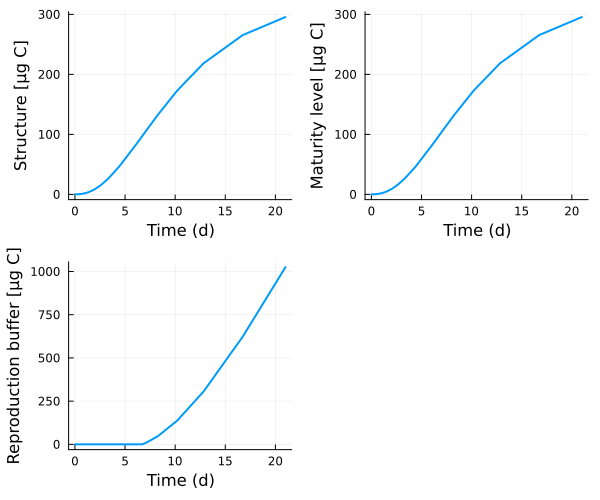

In [7]:
using Plots, StatsPlots
default(leg = false)
@df yhat plot(
    plot(:t, :S, ylabel = "Structure [μg C]"), 
    plot(:t, :S, ylabel = "Maturity level [μg C]"),
    plot(:t, :R, ylabel = "Reproduction buffer [μg C]"), 
    xlabel = "Time (d)", size = (600,500), lw = 2
)

Let's have a closer look at `theta`:

In [8]:
theta

DEBParamCollection
  glb: GlobalParams
  spc: SpeciesParams
  agn: AgentParams


`theta` is a `DEBParamCollection` which in turn contains three parameter objects:

- `glb`: The global parameters, such as simulation time, food influx rate, etc.
- `spc`: The species-specific parameters. This comprises Dynamic Energy Budget (DEB) parameters, Toxicokinetic-Toxicodynamic (TKTD) parameters and some auxiliary parameters.
- `agn`: The agent-specific parameters. These are modified internally and we don't need to do anything with them. 

Why do we need `agn` then? Firstly, this alludes to the implementation of agent-based models, which are not part of the current release yet (but coming soon, I promise ;). <br>
Secondly, `agn`  will be used internally when we add individual variability.

## Simulating individual variability

Let's add individual variability then and simultaneously learn how to modify parameters. <br>
If we further inspect, the `spc` parameters, we see that they have different types:

In [9]:
theta.spc

SpeciesParams
  Z: Distributions.Dirac{Float64}
  propagate_zoom: @NamedTuple{X_emb_int::Bool, H_p::Bool, K_X::Bool}
  X_emb_int: Float64 19.42
  K_X: Float64 1.0
  Idot_max_rel: Float64 22.9
  Idot_max_rel_emb: Float64 22.9
  kappa: Float64 0.539
  eta_IA: Float64 0.33
  eta_AS: Float64 0.8
  eta_SA: Float64 0.8
  eta_AR: Float64 0.95
  k_M: Float64 0.59
  k_J: Float64 0.504
  H_p: Float64 100.0
  e_S: Float64 0.5
  b_S: Float64 5.0
  k_D_G: Array{Float64}((1,)) [0.0]
  k_D_M: Array{Float64}((1,)) [0.0]
  k_D_A: Array{Float64}((1,)) [0.0]
  k_D_R: Array{Float64}((1,)) [0.38]
  k_D_h: Array{Float64}((1,)) [0.0]
  drc_functs_G: Array{Function}((1,))
  drc_functs_M: Array{Function}((1,))
  drc_functs_A: Array{Function}((1,))
  drc_functs_R: Array{Function}((1,))
  drc_functs_h: Array{Function}((1,))
  e_G: Array{Float64}((1,)) [1.0e10]
  e_M: Array{Float64}((1,)) [1.0e10]
  e_A: Array{Float64}((1,)) [1.0e10]
  e_R: Array{Float64}((1,)) [167.0]
  e_h: Array{Float64}((1,)) [1.0e10]
  b_G: 

The first parameter `Z` is the zoom factor. Hydra implements the zoom factor as a ratio between the maximum structural masses of two organisms (not the structural length, as for example done in add-my-pet!). <br>

Above we see that `Z` is not a scalar, but a distribution, and by default set to a Dirac distribution with value 1. That means that there is no individual variability implied in the parameters. <br>

We can introduce individual variability by setting `Z` to some distribution. 
Here we need to be careful that the limits of the distribution do not exceed $[0,\infty]$.

In [10]:
using Distributions
theta.spc.Z = Truncated(Normal(1, 0.1), 0, Inf)

Truncated(Normal{Float64}(μ=1.0, σ=0.1); lower=0.0, upper=Inf)

The same could by the way be achieved like this:

In [11]:
theta = DEBParamCollection( # instantiate the default parameters
    spc = SpeciesParams(Z = Truncated(Normal(1, 0.1), 0, Inf)) # modify the species parameters
)

DEBParamCollection
  glb: GlobalParams
  spc: SpeciesParams
  agn: Nothing nothing


To get a useful output with these parameters, it makes sense to run multiple realizations of the parameters. <br>
The `@replicates` macro makes this easy:

In [36]:
yhat = @replicates simulator(theta) 10;

Above we have repeated our call to `simulator(theta)` 10 times, each time with a new sample from `Z`. <br>
The results now contain a new column `replicate`, which we can use to tell apart the individuals:

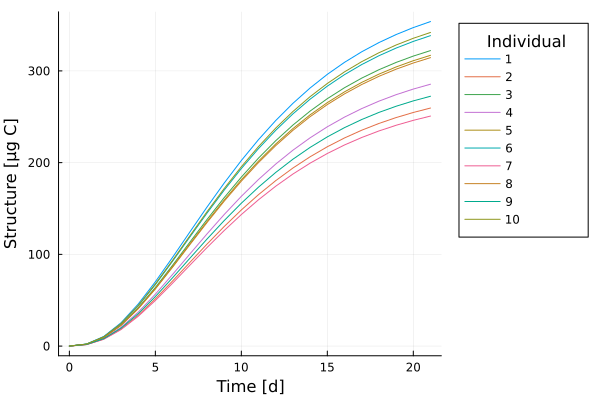

In [37]:
sort!(yhat, :replicate)
@df yhat plot(
    :t, :S, group = :replicate, 
    legend = :outertopright, 
    label = hcat(unique(:replicate)...), 
    legendtitle = "Individual",
    xlabel = "Time [d]", ylabel = "Structure [μg C]")

Hydra also provides the `lineplot` and `groupedlineplot` functions, which can help to visualize this kind of data:

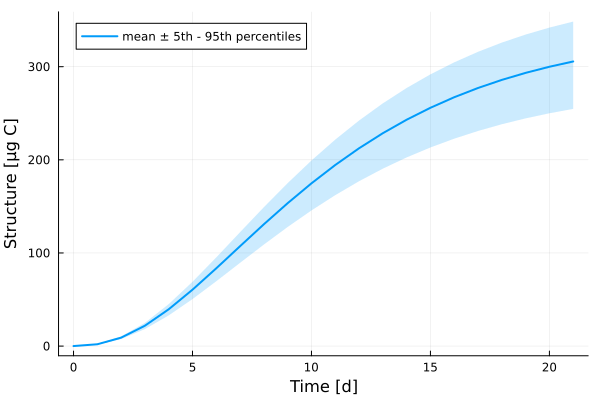

In [39]:
sort!(yhat, :t)
@df yhat lineplot(
    :t, :S, 
    lw = 2, fillalpha = .2, 
    xlabel = "Time [d]", ylabel = "Structure [μg C]", 
    leg = true, label = "mean ± 5th - 95th percentiles"
    )

## Simulating chemical effects

When it comes to simulating chemical effects, Hydra introduces some novelties:

- There is no explicit *stress* function. Damage is directly translated in a relative response `y_j`, specific for physiological mode of action (PMoA) `j`. The relative response is whatever we need to multiply with the relevant term(s) to get the assumed response. Differences between PMoAs are dealt with in the definition of the dose-response functions.
- Dose-response functions are not hard-coded, but passed on as model (hyper-)parameters. 
- An arbitrary number of mixture components and combination of PMoAs can be simulated without chaning the model code (we assume independent action by default).

How does this work in practices? Let's start with a simple example.

### Simulating a single stressor

Below we simulate the effects of a single stressor from default parameters (the PMoA is decrease in reproduction efficiency).

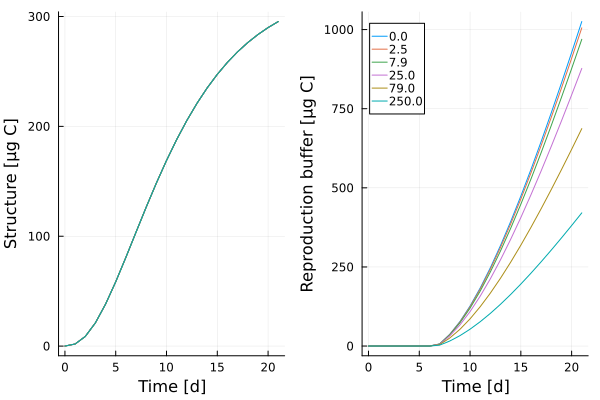

In [40]:
using DataFrames
theta.spc.Z = Dirac(1.) # reset individual variability
C_W = vcat([0.], 10 .^ range(log10(2.5), log10(250), length = 5)) # create a geometric serioes of exposure concentrations

yhat = DataFrame() # instantiate an output object

for c in C_W # for every exposure concentration
    theta.glb.C_W = [c] # update the global parameter
    yhat_c = simulator(theta) # run the simulation
    append!(yhat, yhat_c) # add the result to the output object
end

theta.glb.C_W = [0.] # reset exposure concentration

@df yhat plot( # plot the trajectories
    plot(:t, :S, group = :C_W_1, ylabel = "Structure [μg C]"),
    plot(:t, :R, group = :C_W_1, ylabel = "Reproduction buffer [μg C]", leg = true, 
    label = hcat(unique(round.(:C_W_1, sigdigits = 2))...)), 
    xlabel = "Time [d]"
)

Note that he (constant) exposure concentration `C_W` is a `Vector{Float64}`. Each element corresponds to a mixture component. If we don't want to simulate a mixture, we give only a single value. <br>
In the output, Hydra automatically translates this to a column `C_W_1`, where the suffix `1` corresponds to the position of the mixture component in the input vector.
<br>
By default, we assume log-logistic relaltionships between damage and relative response (for increase in maintenance costs, we use the cumulative hazard function of the log-logistic distribution shifted to intersect the y-axis at a value of 1).

Here we do the same with a different dose-response function, using the often-used linear relationship with a threshold concentration:

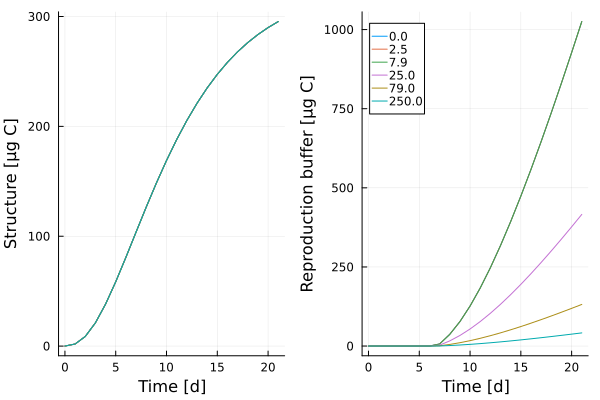

In [41]:
theta.spc.drc_functs_R = [NEC2neg] # use decreasing NEC function instead of log-logistic
theta.spc.e_R = [10.] # adjust the sensitivity parameter (NEC)
theta.spc.b_R = [0.1] # adjust the slope parameter

yhat = DataFrame()

for c in C_W
    theta.glb.C_W = [c]
    yhat_c = simulator(theta)
    append!(yhat, yhat_c)
end

theta.glb.C_W = [0.] # reset exposure concentration

@df yhat plot(
    plot(:t, :S, group = :C_W_1, ylabel = "Structure [μg C]"),
    plot(:t, :R, group = :C_W_1, ylabel = "Reproduction buffer [μg C]", leg = true, 
    label = hcat(unique(round.(:C_W_1, sigdigits = 2))...)), 
    xlabel = "Time [d]"
)

Here we have not simply changed the dose-response *parameters* but passed on a different mathematical formulation for the relationship between damage and effect! The same could be done with any user-defined dose-response function (look at `Hydra/src/DoseResponse.jl` for a collection of examples).

The parameters for different PMoAs are given as seperate vectors, where the suffix indicates the PMoA:

In [42]:
theta.spc.k_D_G # dominant rate constants PMoA G (decrease in growth efficiency)
theta.spc.k_D_M # dominant rate constants PMoA M (increase in maintenance costs)
theta.spc.k_D_A # dominant rate constants PMoA A (decrease in assimilation efficiency)
theta.spc.k_D_R # dominant rate constants PMoA R (decrease in reproduction efficiency)
theta.spc.k_D_h # dominant rate constants PMoA h (hazard rate (GUTS-RED-SD))

theta.spc.e_G # sensitivity parameter PMoA G (decrease in growth efficiency)
theta.spc.e_M # sensitivity parameter PMoA M (increase in maintenance costs)
theta.spc.e_A # sensitivity parameter PMoA A (decrease in assimilation efficiency)
theta.spc.e_R # sensitivity parameter PMoA R (decrease in reproduction efficiency)
theta.spc.e_h # sensitivity parameter PMoA h (hazard rate (GUTS-RED-SD))

theta.spc.b_G # slope parameter PMoA G (decrease in growth efficiency)
theta.spc.b_M # slope parameter PMoA M (increase in maintenance costs)
theta.spc.b_A # slope parameter PMoA A (decrease in assimilation efficiency)
theta.spc.b_R # slope parameter PMoA R (decrease in reproduction efficiency)
theta.spc.b_h # slope parameter PMoA h (hazard rate (GUTS-RED-SD))

1-element Vector{Float64}:
 1.0e10

PMoAs are disengaged by setting the corresponding `k_D`-values to 0 or calling the `Hydra.isolate_pmoas!()` function:

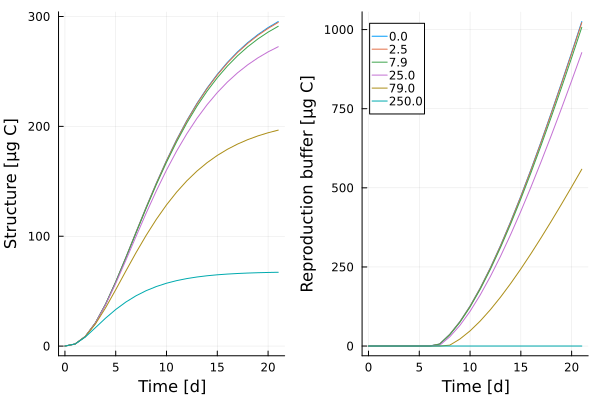

In [43]:
theta.spc.k_D_M = [1.] # engage PMoA M
theta.spc.e_M = [250.] # set parameters for PMoA M
theta.spc.b_M = [1.5]

Hydra.isolate_pmoas!(theta.spc, ["M"]) # disengage all PMoAs but M

yhat = DataFrame()

for c in C_W
    theta.glb.C_W = [c]
    yhat_c = simulator(theta)
    append!(yhat, yhat_c)
end

theta.glb.C_W = [0.] # reset exposure concentration

@df yhat plot(
    plot(:t, :S, group = :C_W_1, ylabel = "Structure [μg C]"),
    plot(:t, :R, group = :C_W_1, ylabel = "Reproduction buffer [μg C]", leg = true, 
    label = hcat(unique(round.(:C_W_1, sigdigits = 2))...)), 
    xlabel = "Time [d]"
)

## Modifying the model equations

We have previosuly learned that in Hydra, the dose-response functions for chemicals are model parameters, 
rather than hard-coded. <br>
The same is actually true for all derivatives of the ODE system! <br>
The functions which apply to individuals are given in the `SpeciesParams`:

In [44]:
theta.spc.odefuncs

12-element Vector{Function}:
 y_z! (generic function with 1 method)
 h_S! (generic function with 1 method)
 Idot! (generic function with 1 method)
 Adot! (generic function with 1 method)
 Mdot! (generic function with 1 method)
 Jdot! (generic function with 1 method)
 Sdot! (generic function with 1 method)
 Hdot! (generic function with 1 method)
 H_bdot! (generic function with 1 method)
 Rdot! (generic function with 1 method)
 Ddot! (generic function with 1 method)
 age! (generic function with 1 method)

And the functions which apply to the global environment are given in the `GlobalParams`:

In [45]:
theta.glb.odefuncs

2-element Vector{Function}:
 C_Wdot_const! (generic function with 1 method)
 X_pdot_chemstat! (generic function with 1 method)

Knowing that, we can modify the model without modifying any of the code in `Hydra.jl`. <br>
Let's say we want to eliminate the DEB assumption that the assimilation efficiency is constant, but instead a function of food uptake (as done first by [Rinke & Vijverberg](https://www.tandfonline.com/doi/pdf/10.1080/03680770.2005.11902020?casa_token=O4jZWN4DznAAAAAA:-lZl_J6RJNbs-1hVSi2I9yY89T2EqiMpD2Wrp_gl-mzRKcak_yiByAZlswsa5Uxar_bFaNuTAx4) and later imitated by [Hansul et al.](https://www.tandfonline.com/doi/pdf/10.1080/03680770.2005.11902020?casa_token=O4jZWN4DznAAAAAA:-lZl_J6RJNbs-1hVSi2I9yY89T2EqiMpD2Wrp_gl-mzRKcak_yiByAZlswsa5Uxar_bFaNuTAx4)). <br>
To do so, we can write a new function for the assimilation flux `Adot!()`:

In [70]:
"""
Calculate food-variable assimilation efficiency. 
"""
function calc_eta_IA!(du, u, p, t)
    p.spc.eta_IA = u.agn.y_A * p.spc.eta_IA_max - (p.spc.eta_IA_max - p.spc.eta_IA_min) * u.agn.f_X
end

calc_eta_IA!

Here we have introduced new parameters `eta_IA_max` and `eta_IA_min`, which are the maximum and minimum assimilation efficiencies, respecitively. <br>
We need to add these to the `SpeciesParams`:

In [71]:
NewParams = Hydra.childstruct(
    SpeciesParams, # structure to which we want to add additional parameters
    [:eta_IA_max, :eta_IA_min],  # names of new parameters
    [Float64, Float64], # types of new parameters
    [0.9, 0.5] # default values of new parameters (taken from Rinke & Vijverberg)
)
spc = NewParams() # instantiate the new parameters
pushfirst!(spc.odefuncs, calc_eta_IA!) # calculate modified eta_IA at the beginning of each step
println("$(spc.eta_IA_min), $(spc.eta_IA_max) \n $(spc.odefuncs)") # print the new values

0.5, 0.9 
 Function[calc_eta_IA!, Hydra.y_z!, Hydra.h_S!, Hydra.Idot!, Hydra.Adot!, Hydra.Mdot!, Hydra.Jdot!, Hydra.Sdot!, Hydra.Hdot!, Hydra.H_bdot!, Hydra.Rdot!, Hydra.Ddot!, Hydra.age!]


Now we can make a parameter collection with our new parameters.

In [72]:
theta = DEBParamCollection(
    glb = GlobalParams(),
    spc = NewParams()
)

DEBParamCollection
  glb: GlobalParams
  spc: Hydra.ChildParamType_ngvymgejfq
  agn: Nothing nothing


Let's simulate different food levels to see the new model in action!

In [73]:
using Hydra

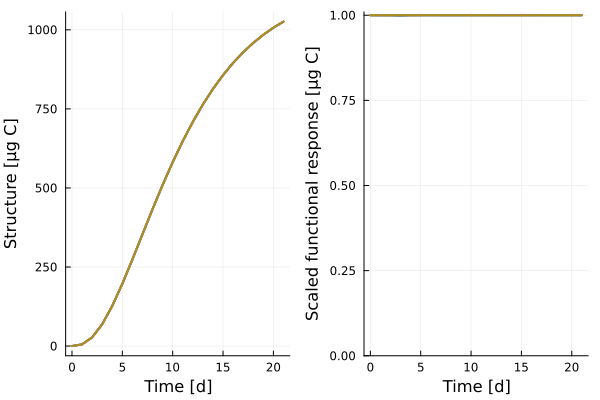

In [74]:
using OrdinaryDiffEq
yhat_vareta = DataFrame() # simulations with variable eta_IA

Xvec = GlobalParams().Xdot_in .* 10 .^ range(log10(0.1), log10(1.), length = 5)

for X in Xvec # for every food input rate
    theta.glb.Xdot_in = X # assign parameter
    yhat_X = simulator(theta; alg = Tsit5()) # run simulation
    yhat_X[!,:Xdot_in] .= X # add a column with the food treatment
    append!(yhat_vareta, yhat_X) 
end
theta.glb.Xdot_in = GlobalParams().Xdot_in # reset to default value

@df yhat_vareta plot(
    plot(:t, :S, group = :Xdot_in, ylabel = "Structure [μg C]"), 
    plot(:t, :f_X, group = :Xdot_in, ylabel = "Scaled functional response [μg C]", ylim = (0,1.01)), 
    lw = 2, xlabel = "Time [d]"
)

In [ ]:
yhat_vareta = DataFrame() # simulations with variable eta_IA

Xvec = GlobalParams().Xdot_in .* 10 .^ range(log10(0.1), log10(1.), length = 5)

for X in Xvec # for every food input rate
    theta.glb.Xdot_in = X # assign parameter
    yhat_X = simulator(theta) # run simulation
    yhat_X[!,:Xdot_in] .= X # add a column with the food treatment
    append!(yhat_vareta, yhat_X) 
end
theta.glb.Xdot_in = GlobalParams().Xdot_in # reset to default value

@df yhat_vareta plot(
    plot(:t, :S, group = :Xdot_in, ylabel = "Structure [μg C]"), 
    plot(:t, :f_X, group = :Xdot_in, ylaebel = "Scaled functional response [μg C]"), 
    lw = 2, xlabel = "Time [d]"
)

In [54]:
Xvec

5-element Vector{Float64}:
  120.0
  213.39352920467076
  379.47331922020555
  674.8095902284189
 1200.0